# Проект: Линейная и логистическая регрессия с нуля

**Участник:** Гаськов Валерий

**Описание:** В проекте реализованы:
- Линейная регрессия с градиентным спуском (batch и mini-batch)
- Логистическая регрессия с градиентным спуском (binary и multiclass)
- Классификация с дополнительной моделью Random Forest
- Метрики: accuracy, precision, recall, F1-score, confusion matrix, ROC AUC (для бинарной классификации)
- Интерактивный интерфейс с виджетами для настройки гиперпараметров и выбора модели

**Датасет:**  
Использован публичный датасет `master.csv`  
Источник: [Kaggle — Suicide Rates Overview 1985 to 2016](https://www.kaggle.com/datasets/russellyates88/suicide-rates-overview-1985-to-2016/discussion/570568)


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

df = pd.read_csv("master.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  object 
 3   age                 27820 non-null  object 
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides/100k pop   27820 non-null  float64
 7   country-year        27820 non-null  object 
 8   HDI for year        8364 non-null   float64
 9    gdp_for_year ($)   27820 non-null  object 
 10  gdp_per_capita ($)  27820 non-null  int64  
 11  generation          27820 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


# Формулы градиентов линейной регрессии:
$
\hat y = wX + b
$

Функция потерь (MSE):
$
L=\frac{1}{N}\sum (y - \hat y)^2
$

Градиенты:
$
frac{\partial L}{\partial w} = -\frac{2}{N}\sum X(y - \hat y)
$
$
frac{\partial L}{\partial b} = -\frac{2}{N}\sum (y - \hat y)
$

# Задача 1
Линейная регрессия (реализация с нуля).
Реализовать градиентный спуск (batch или mini-batch) для обучения линейной регрессии.
Вывести и показать: функция потерь (MSE), график потерь по эпохам, влияние скорости обучения (learning rate), найденные коэффициент и интерсепт.
На странице/в ноутбуке — scatter plot данных и линия регрессии с доверительным интервалом.


Функция MSE

In [15]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

Batch Gradient Descent — реализация вручную

In [16]:
def train_linear_regression(X, y, lr=0.01, epochs=1000):
    n = X.shape[0]


    w = 0.0
    b = 0.0

    history = []

    for _ in tqdm(range(epochs)):
        y_pred = w * X + b

        error = y_pred - y

        dw = (2/n) * np.sum(error * X)
        db = (2/n) * np.sum(error)

        w -= lr * dw
        b -= lr * db

        history.append(mse(y, y_pred))

    return w, b, history

Mini-Batch Gradient Descent

In [17]:
def train_linear_regression_minibatch(X, y, lr=0.01, epochs=1000, batch_size=32):
    n = X.shape[0]
    w = 0.0
    b = 0.0
    history = []

    for _ in tqdm(range(epochs)):
        indices = np.random.permutation(n)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        for start in range(0, n, batch_size):
            end = start + batch_size
            Xb = X_shuffled[start:end]
            yb = y_shuffled[start:end]

            pred = w * Xb + b
            err = pred - yb

            dw = (2/len(Xb)) * np.sum(err * Xb)
            db = (2/len(Xb)) * np.sum(err)

            w -= lr * dw
            b -= lr * db

        pred_full = w * X + b
        history.append(mse(y, pred_full))

    return w, b, history


Запуск обучения + эксперименты с learning rate

In [18]:
from tqdm.notebook import tqdm

X = df['population'].values.reshape(-1, 1)
y = df['suicides/100k pop'].values.reshape(-1, 1)

X_mean = np.mean(X)
X_std = np.std(X)
Xn = (X - X_mean) / X_std

print(f"Shape of Xn: {Xn.shape}")
print(f"Shape of y: {y.shape}")

Shape of Xn: (27820, 1)
Shape of y: (27820, 1)


In [19]:
lrs = [0.001, 0.01, 0.1]

results = {}

for lr in lrs:
    w, b, h = train_linear_regression(Xn, y, lr=lr, epochs=300)
    results[lr] = (w, b, h)
    print(f"LR={lr} → w={w:.4f}, b={b:.4f}, final MSE={h[-1]:.4f}")

  0%|          | 0/300 [00:00<?, ?it/s]

LR=0.001 → w=0.0709, b=5.7867, final MSE=409.1194


  0%|          | 0/300 [00:00<?, ?it/s]

LR=0.01 → w=0.1567, b=12.7862, final MSE=359.5022


  0%|          | 0/300 [00:00<?, ?it/s]

LR=0.1 → w=0.1571, b=12.8161, final MSE=359.5013


График потерь для разных learning rate

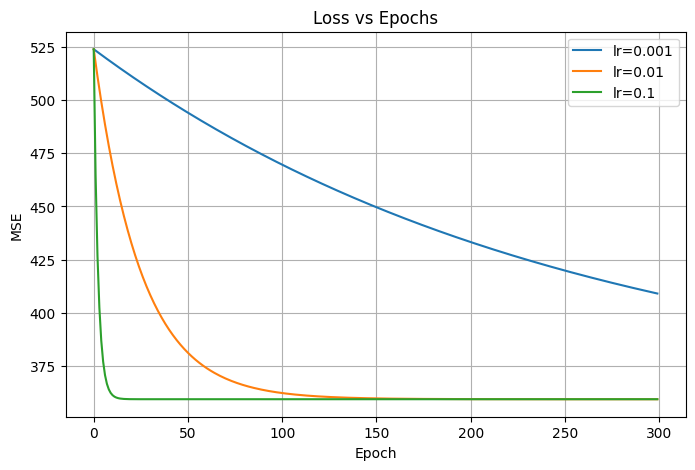

In [20]:
plt.figure(figsize=(8,5))
for lr in lrs:
    _, _, h = results[lr]
    plt.plot(h, label=f"lr={lr}")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

Построение линии регрессии

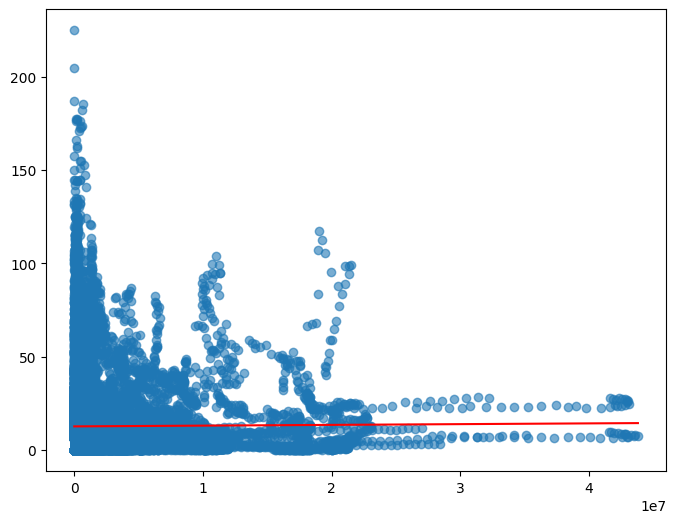

In [21]:
lr = 0.01
w, b, h = results[lr]

y_pred = w * Xn + b

X_sorted = np.sort(X, axis=0)
Xn_sorted = (X_sorted - X_mean) / X_std
y_pred_sorted = w * Xn_sorted + b

plt.figure(figsize=(8,6))
plt.scatter(X, y, alpha=0.6, label="Data")
plt.plot(X_sorted, y_pred_sorted, 'r', label="Regression line")

 Доверительный интервал

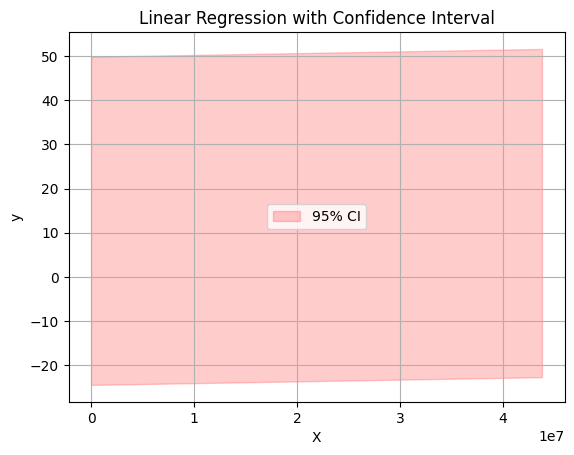

In [22]:
errors = y - y_pred
sigma = errors.std()
ci_upper = y_pred_sorted + 1.96 * sigma
ci_lower = y_pred_sorted - 1.96 * sigma
plt.fill_between(X_sorted.flatten(), ci_lower.flatten(), ci_upper.flatten(),
                 color='red', alpha=0.2, label="95% CI")

plt.xlabel("X")
plt.ylabel("y")
plt.title("Linear Regression with Confidence Interval")
plt.legend()
plt.grid(True)
plt.show()

# Логистическая регрессия (реализация с нуля).
Реализовать лог-функцию, сигмоиду и обучение градиентным спуском (можно использовать регуляризацию L2 по желанию).


Модель:
$z = X w + b,\quad \hat{p} = \sigma(z) = \frac{1}{1 + e^{-z}}$

Функция потерь:
$L = -\frac{1}{N} \sum_{i=1}^{N} \Big[ y_i \log \hat{p}_i + (1 - y_i) \log (1 - \hat{p}_i) \Big]$

Градиенты:

$\frac{\partial L}{\partial w} = \frac{1}{N} X^\top (\hat{p} - y)$

$\frac{\partial L}{\partial b} = \frac{1}{N} \sum_{i=1}^{N} (\hat{p}_i - y_i)$


Базовые функции

In [23]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def binary_cross_entropy(y_true, y_pred):
    eps = 1e-8
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

Batch Gradient Descent (без L2)

In [24]:
def train_logistic_regression(X, y, lr=0.01, epochs=1000, l2_lambda=0.0):
    n_samples, n_features = X.shape
    w = np.zeros((n_features, 1))
    b = 0.0
    history = []

    for _ in range(epochs):
        z = X.dot(w) + b
        y_pred = sigmoid(z)

        dw = (1/n_samples) * X.T.dot(y_pred - y) + l2_lambda * w
        db = (1/n_samples) * np.sum(y_pred - y)

        w -= lr * dw
        b -= lr * db

        loss = binary_cross_entropy(y, y_pred)
        history.append(loss)

    return w, b, history

Метрика точности

In [25]:
def predict(X, w, b, threshold=0.5):
    y_prob = sigmoid(X.dot(w) + b)
    return (y_prob >= threshold).astype(int)

График потерь

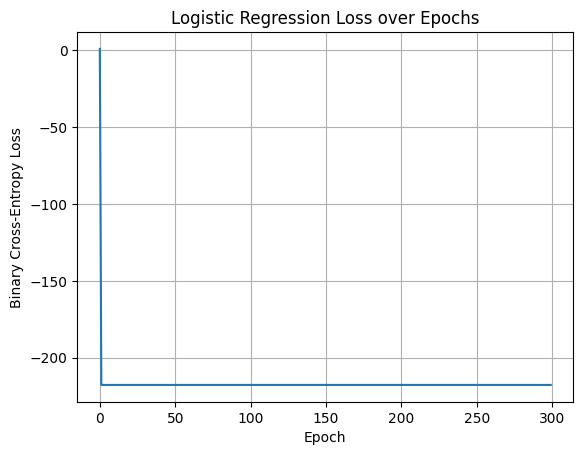

In [26]:
import matplotlib.pyplot as plt

w, b, history = train_logistic_regression(X, y, lr=0.1, epochs=300)

plt.plot(history)
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Logistic Regression Loss over Epochs")
plt.grid(True)
plt.show()

Проверка точности на обучающей выборке

In [27]:
y_pred = predict(X, w, b)
accuracy = np.mean(y_pred == y)
print(f"Accuracy on training set: {accuracy:.4f}")

Accuracy on training set: 0.0010


# Задача 3. Классификация (binary / multiclass)

In [28]:
classes = np.unique(y)
if len(classes) > 2:
    print("Multiclass classification (one-vs-rest)")
else:
    print("Binary classification")

Multiclass classification (one-vs-rest)


Логистическая регрессия (из пункта 2)

In [32]:
from sklearn.preprocessing import LabelEncoder

le_sex = LabelEncoder()
y_binary = le_sex.fit_transform(df['sex']).reshape(-1, 1)

print(f"Unique values in y_binary: {np.unique(y_binary)}")
print(f"Shape of y_binary: {y_binary.shape}")

le_age = LabelEncoder()
y_multi = le_age.fit_transform(df['age']).reshape(-1, 1)
age_classes = le_age.classes_

print(f"Unique values in y_multi: {np.unique(y_multi)}")
print(f"Shape of y_multi: {y_multi.shape}")
print(f"Age classes: {age_classes}")

Unique values in y_binary: [0 1]
Shape of y_binary: (27820, 1)
Unique values in y_multi: [0 1 2 3 4 5]
Shape of y_multi: (27820, 1)
Age classes: ['15-24 years' '25-34 years' '35-54 years' '5-14 years' '55-74 years'
 '75+ years']


In [33]:
w_bin, b_bin, history_bin = train_logistic_regression(Xn, y_binary, lr=0.1, epochs=300)

y_pred_bin = predict(Xn, w_bin, b_bin)
accuracy_bin = np.mean(y_pred_bin == y_binary)
print(f"Binary Logistic Regression accuracy (sex): {accuracy_bin:.4f}")

Binary Logistic Regression accuracy (sex): 0.5051


Модель и прогноз:

$\hat{p} = \sigma(z) = \frac{1}{1 + e^{-z}}, \quad z = X w + b$


Функция потерь (binary cross-entropy):

$L = -\frac{1}{N} \sum_{i=1}^{N} \Big[ y_i \log \hat{p}_i + (1 - y_i) \log (1 - \hat{p}_i) \Big]$


Градиенты по весам и смещению:

$\frac{\partial L}{\partial w} = \frac{1}{N} X^\top (\hat{p} - y)$

$\frac{\partial L}{\partial b} = \frac{1}{N} \sum_{i=1}^{N} (\hat{p}_i - y_i)$

Multiclass Logistic Regression (one-vs-rest)

In [34]:
n_classes = len(age_classes)
w_multi = []
b_multi = []

for cls_idx in range(n_classes):
    y_cls = (y_multi == cls_idx).astype(int)
    w, b, _ = train_logistic_regression(Xn, y_cls, lr=0.1, epochs=300)
    w_multi.append(w)
    b_multi.append(b)

pred_probs = np.column_stack([sigmoid(Xn.dot(w)+b) for w,b in zip(w_multi,b_multi)])
y_pred_multi = np.argmax(pred_probs, axis=1)

accuracy_multi = np.mean(y_pred_multi.reshape(-1,1) == y_multi)
print(f"Multiclass Logistic Regression accuracy (age): {accuracy_multi:.4f}")

Multiclass Logistic Regression accuracy (age): 0.2048


Random Forest (sklearn)

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_bin = RandomForestClassifier(n_estimators=100, random_state=42)
rf_bin.fit(Xn, y_binary.ravel())
y_pred_rf_bin = rf_bin.predict(Xn)
accuracy_rf_bin = accuracy_score(y_binary, y_pred_rf_bin)
print(f"Random Forest accuracy (binary sex): {accuracy_rf_bin:.4f}")

rf_multi = RandomForestClassifier(n_estimators=100, random_state=42)
rf_multi.fit(Xn, y_multi.ravel())
y_pred_rf_multi = rf_multi.predict(Xn)
accuracy_rf_multi = accuracy_score(y_multi, y_pred_rf_multi)
print(f"Random Forest accuracy (multiclass age): {accuracy_rf_multi:.4f}")

Random Forest accuracy (binary sex): 0.9670
Random Forest accuracy (multiclass age): 0.9472


Сравнение моделей и график

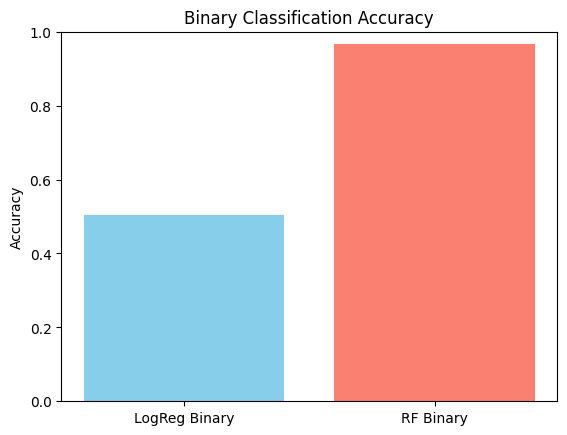

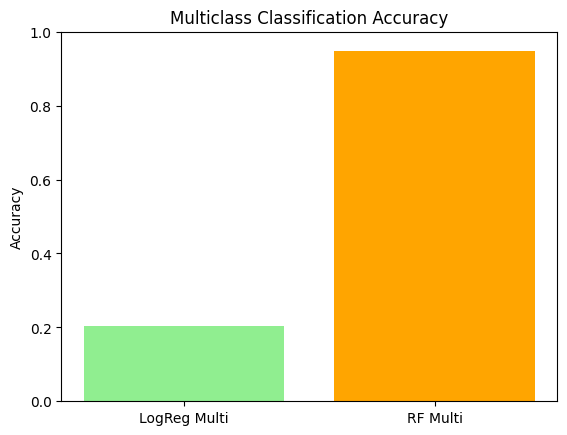

In [36]:
plt.bar(["LogReg Binary", "RF Binary"], [accuracy_bin, accuracy_rf_bin], color=['skyblue','salmon'])
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Binary Classification Accuracy")
plt.show()

plt.bar(["LogReg Multi", "RF Multi"], [accuracy_multi, accuracy_rf_multi], color=['lightgreen','orange'])
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Multiclass Classification Accuracy")
plt.show()

# Метрики для всех моделей

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

def evaluate_classification(y_true, y_pred, y_prob=None, binary=False):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='binary' if binary else 'macro')
    rec = recall_score(y_true, y_pred, average='binary' if binary else 'macro')
    f1 = f1_score(y_true, y_pred, average='binary' if binary else 'macro')
    cm = confusion_matrix(y_true, y_pred)

    print("Accuracy:", round(acc,4))
    print("Precision:", round(prec,4))
    print("Recall:", round(rec,4))
    print("F1-score:", round(f1,4))
    print("Confusion Matrix:\n", cm)

    if binary and y_prob is not None:
        auc = roc_auc_score(y_true, y_prob)
        print("ROC AUC:", round(auc,4))
        return acc, prec, rec, f1, cm, auc
    return acc, prec, rec, f1, cm

Применение для логистической регрессии (binary):


In [38]:
y_pred_prob_bin = sigmoid(Xn.dot(w_bin) + b_bin)
evaluate_classification(y_binary, y_pred_bin, y_pred_prob_bin, binary=True)

Accuracy: 0.5051
Precision: 0.5033
Recall: 0.7784
F1-score: 0.6114
Confusion Matrix:
 [[ 3225 10685]
 [ 3082 10828]]
ROC AUC: 0.5106


(0.5051401869158878,
 0.503323571793799,
 0.7784327821710999,
 0.6113542048951246,
 array([[ 3225, 10685],
        [ 3082, 10828]]),
 np.float64(0.5105924912178061))

Для multiclass или Random Forest:

In [39]:
evaluate_classification(y_multi, y_pred_multi, binary=False)
evaluate_classification(y_multi, y_pred_rf_multi, binary=False)

Accuracy: 0.2048
Precision: 0.1534
Recall: 0.2045
F1-score: 0.1108
Confusion Matrix:
 [[   5  120 1087    0   60 3370]
 [   5  127 1098    0   17 3395]
 [  11  255 1313    0   86 2977]
 [   9  152 1016    0  108 3325]
 [   8   77 1014    0   94 3449]
 [   3  104  316    0   61 4158]]
Accuracy: 0.9472
Precision: 0.9473
Recall: 0.9472
F1-score: 0.9472
Confusion Matrix:
 [[4406   55   21   71   41   48]
 [  59 4381   33   71   34   64]
 [  49   43 4431   38   34   47]
 [  65   62   28 4358   51   46]
 [  41   47   33   56 4390   75]
 [  55   39   40   50   72 4386]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.9472322070452912,
 0.9472845072022015,
 0.9472300286952136,
 0.9472450837281937,
 array([[4406,   55,   21,   71,   41,   48],
        [  59, 4381,   33,   71,   34,   64],
        [  49,   43, 4431,   38,   34,   47],
        [  65,   62,   28, 4358,   51,   46],
        [  41,   47,   33,   56, 4390,   75],
        [  55,   39,   40,   50,   72, 4386]]))

Эксперименты с hyperparameters

In [42]:
def train_logistic_regression_minibatch(X, y, lr=0.01, epochs=1000, batch_size=32, l2_lambda=0.0):
    n_samples, n_features = X.shape
    w = np.zeros((n_features, 1))
    b = 0.0
    history = []

    for _ in tqdm(range(epochs)):
        indices = np.random.permutation(n_samples)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        for start in range(0, n_samples, batch_size):
            end = start + batch_size
            Xb = X_shuffled[start:end]
            yb = y_shuffled[start:end]

            if len(Xb) == 0:
                continue

            z = Xb.dot(w) + b
            y_pred = sigmoid(z)

            dw = (1/len(Xb)) * Xb.T.dot(y_pred - yb) + l2_lambda * w
            db = (1/len(Xb)) * np.sum(y_pred - yb)

            w -= lr * dw
            b -= lr * db

        z_full = X.dot(w) + b
        y_pred_full = sigmoid(z_full)
        loss = binary_cross_entropy(y, y_pred_full)
        history.append(loss)

    return w, b, history

In [43]:
lrs = [0.001, 0.01, 0.1]
epochs_list = [100, 300, 500]
batch_sizes = [16, 32, 64]

for lr in lrs:
    for epochs in epochs_list:
        for batch in batch_sizes:
            w, b, h = train_logistic_regression_minibatch(Xn, y_binary, lr=lr, epochs=epochs, batch_size=batch)
            print(f"LR={lr}, epochs={epochs}, batch={batch}, final loss={h[-1]:.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

LR=0.001, epochs=100, batch=16, final loss=0.6931


  0%|          | 0/100 [00:00<?, ?it/s]

LR=0.001, epochs=100, batch=32, final loss=0.6931


  0%|          | 0/100 [00:00<?, ?it/s]

LR=0.001, epochs=100, batch=64, final loss=0.6931


  0%|          | 0/300 [00:00<?, ?it/s]

LR=0.001, epochs=300, batch=16, final loss=0.6931


  0%|          | 0/300 [00:00<?, ?it/s]

LR=0.001, epochs=300, batch=32, final loss=0.6931


  0%|          | 0/300 [00:00<?, ?it/s]

LR=0.001, epochs=300, batch=64, final loss=0.6931


  0%|          | 0/500 [00:00<?, ?it/s]

LR=0.001, epochs=500, batch=16, final loss=0.6931


  0%|          | 0/500 [00:00<?, ?it/s]

LR=0.001, epochs=500, batch=32, final loss=0.6931


  0%|          | 0/500 [00:00<?, ?it/s]

LR=0.001, epochs=500, batch=64, final loss=0.6931


  0%|          | 0/100 [00:00<?, ?it/s]

LR=0.01, epochs=100, batch=16, final loss=0.6931


  0%|          | 0/100 [00:00<?, ?it/s]

LR=0.01, epochs=100, batch=32, final loss=0.6931


  0%|          | 0/100 [00:00<?, ?it/s]

LR=0.01, epochs=100, batch=64, final loss=0.6931


  0%|          | 0/300 [00:00<?, ?it/s]

LR=0.01, epochs=300, batch=16, final loss=0.6932


  0%|          | 0/300 [00:00<?, ?it/s]

LR=0.01, epochs=300, batch=32, final loss=0.6931


  0%|          | 0/300 [00:00<?, ?it/s]

LR=0.01, epochs=300, batch=64, final loss=0.6931


  0%|          | 0/500 [00:00<?, ?it/s]

LR=0.01, epochs=500, batch=16, final loss=0.6931


  0%|          | 0/500 [00:00<?, ?it/s]

LR=0.01, epochs=500, batch=32, final loss=0.6931


  0%|          | 0/500 [00:00<?, ?it/s]

LR=0.01, epochs=500, batch=64, final loss=0.6931


  0%|          | 0/100 [00:00<?, ?it/s]

LR=0.1, epochs=100, batch=16, final loss=0.6936


  0%|          | 0/100 [00:00<?, ?it/s]

LR=0.1, epochs=100, batch=32, final loss=0.6935


  0%|          | 0/100 [00:00<?, ?it/s]

LR=0.1, epochs=100, batch=64, final loss=0.6932


  0%|          | 0/300 [00:00<?, ?it/s]

LR=0.1, epochs=300, batch=16, final loss=0.6940


  0%|          | 0/300 [00:00<?, ?it/s]

LR=0.1, epochs=300, batch=32, final loss=0.6931


  0%|          | 0/300 [00:00<?, ?it/s]

LR=0.1, epochs=300, batch=64, final loss=0.6934


  0%|          | 0/500 [00:00<?, ?it/s]

LR=0.1, epochs=500, batch=16, final loss=0.6937


  0%|          | 0/500 [00:00<?, ?it/s]

LR=0.1, epochs=500, batch=32, final loss=0.6935


  0%|          | 0/500 [00:00<?, ?it/s]

LR=0.1, epochs=500, batch=64, final loss=0.6934


# Интерфейс / демонстрация с виджетами (Jupyter / ipywidgets)

In [44]:
import ipywidgets as widgets
from IPython.display import display, clear_output

lr_slider = widgets.FloatLogSlider(value=0.01, base=10, min=-3, max=0, step=0.1, description='LR')
epochs_slider = widgets.IntSlider(value=300, min=50, max=1000, step=50, description='Epochs')
batch_slider = widgets.IntSlider(value=32, min=8, max=128, step=8, description='Batch Size')
model_select = widgets.Dropdown(options=['Logistic Regression', 'Random Forest'], description='Model')
target_select = widgets.Dropdown(options=['sex (binary)', 'age (multiclass)'], description='Target')

button_run = widgets.Button(description="Train & Evaluate")

out = widgets.Output()

def on_button_click(b):
    with out:
        clear_output()
        if target_select.value == 'sex (binary)':
            X_train, y_train = Xn, y_binary
            binary = True
        else:
            X_train, y_train = Xn, y_multi
            binary = False

        if model_select.value == 'Logistic Regression':
            w, b_val, history = train_logistic_regression_minibatch(
                X_train, y_train, lr=lr_slider.value, epochs=epochs_slider.value, batch_size=batch_slider.value
            )
            y_pred = predict(X_train, w, b_val)
            if binary:
                y_prob = sigmoid(X_train.dot(w)+b_val)
                evaluate_classification(y_train, y_pred, y_prob, binary=True)
            else:
                n_classes = len(np.unique(y_train))
                w_all, b_all = [], []
                for cls_idx in range(n_classes):
                    y_cls = (y_train == cls_idx).astype(int)
                    w_tmp, b_tmp, _ = train_logistic_regression(X_train, y_cls, lr=lr_slider.value, epochs=epochs_slider.value)
                    w_all.append(w_tmp)
                    b_all.append(b_tmp)
                pred_probs = np.column_stack([sigmoid(X_train.dot(w)+b) for w,b in zip(w_all,b_all)])
                y_pred_multi = np.argmax(pred_probs, axis=1)
                evaluate_classification(y_train, y_pred_multi, binary=False)

            plt.plot(history)
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.show()
        else:
            from sklearn.ensemble import RandomForestClassifier
            rf = RandomForestClassifier(n_estimators=100, random_state=42)
            rf.fit(X_train, y_train.ravel())
            y_pred = rf.predict(X_train)
            evaluate_classification(y_train, y_pred, binary=binary)

button_run.on_click(on_button_click)

display(lr_slider, epochs_slider, batch_slider, model_select, target_select, button_run, out)

FloatLogSlider(value=0.01, description='LR', max=0.0, min=-3.0)

IntSlider(value=300, description='Epochs', max=1000, min=50, step=50)

IntSlider(value=32, description='Batch Size', max=128, min=8, step=8)

Dropdown(description='Model', options=('Logistic Regression', 'Random Forest'), value='Logistic Regression')

Dropdown(description='Target', options=('sex (binary)', 'age (multiclass)'), value='sex (binary)')

Button(description='Train & Evaluate', style=ButtonStyle())

Output()